## Download MIDI files from VGMusic

In [2]:
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin
from pathlib import Path
import time
import re

# -------------------------------
# CONFIG
# -------------------------------

console_urls = [
    "http://www.vgmusic.com/music/console/snk/neogeo/",
    "https://www.vgmusic.com/music/console/sega/segacd/",
    "https://www.vgmusic.com/music/console/sega/dreamcast/",
    # "https://www.vgmusic.com/music/console/sony/ps1/",
    # Add more console URLs here
]

base_dir = Path("../data/midi_downloads")
base_dir.mkdir(exist_ok=True)

delay_sec = 0.3  # polite delay

# -------------------------------
# FUNCTIONS
# -------------------------------

def clean_name(s):
    """Sanitize string for filenames/folders"""
    s = re.sub(r'[\\/:"*?<>|]+', '', s)  # remove illegal chars
    s = re.sub(r'\s+', '_', s)           # spaces → underscores
    return s.strip('_')

def download_file(url, path: Path):
    """Download a file to the specified path"""
    try:
        response = requests.get(url, stream=True, timeout=15)
        response.raise_for_status()
        path.parent.mkdir(parents=True, exist_ok=True)  # ensure directory exists
        with open(path, "wb") as f:
            for chunk in response.iter_content(chunk_size=8192):
                if chunk:
                    f.write(chunk)
        return True
    except Exception as e:
        print(f"Failed to download {url}: {e}")
        return False

# -------------------------------
# MAIN LOOP
# -------------------------------

total_downloaded = 0

for console_url in console_urls:
    console_name = console_url.rstrip('/').split('/')[-1]
    console_dir = base_dir / console_name
    console_dir.mkdir(exist_ok=True)

    console_downloaded = 0
    current_game = None

    try:
        resp = requests.get(console_url, timeout=15)
        resp.raise_for_status()
    except Exception as e:
        print(f"Failed to fetch {console_url}: {e}")
        continue

    soup = BeautifulSoup(resp.text, "html.parser")

    for tr in soup.find_all("tr"):
        # Check if it's a game header
        if "gameheader" in tr.get("class", []):
            game_td = tr.find("td", class_="header")
            if game_td:
                current_game = clean_name(game_td.get_text(strip=True))
            continue  # header row doesn't contain MIDI link

        # Skip if no current game
        if current_game is None:
            continue

        tds = tr.find_all("td")
        if not tds:
            continue

        link_tag = tds[0].find("a")
        if link_tag and link_tag['href'].endswith(".mid"):
            song_title = clean_name(link_tag.get_text(strip=True))
            midi_url = urljoin(console_url, link_tag['href'])

            filepath = console_dir / current_game / f"{song_title}.mid"

            if download_file(midi_url, filepath):
                console_downloaded += 1
                total_downloaded += 1

            time.sleep(delay_sec)

    print(f"Downloads for {console_name}: {console_downloaded}")

print(f"\nAll downloads completed. Total downloaded: {total_downloaded}")


Downloads for neogeo: 233
Downloads for segacd: 267
Downloads for dreamcast: 300

All downloads completed. Total downloaded: 800


## IGDB API

In [3]:
import requests

CLIENT_ID = "xp8qf5d9u8uwfmf4fvgdbry19zxxdl"
CLIENT_SECRET = "lp2o03p4haqddk7t0mrcj0h5nc89pa"

# Step 1: Get OAuth token
auth_url = "https://id.twitch.tv/oauth2/token"
auth_params = {
    "client_id": CLIENT_ID,
    "client_secret": CLIENT_SECRET,
    "grant_type": "client_credentials"
}

auth_response = requests.post(auth_url, params=auth_params)
auth_data = auth_response.json()
ACCESS_TOKEN = auth_data["access_token"]

In [4]:
import requests
import re
from datetime import datetime, timezone
import difflib

def preprocess_title(raw_title):
    """Preprocess game title for IGDB search."""
    title = raw_title.replace("_", " ")
    title = title.replace(".", "")
    title = re.sub(r'\s+', " ", title)
    return title.strip()

def get_first_release_year(release_dates):
    """Return the year of the earliest release."""
    if not release_dates:
        return None
    dates_with_timestamp = [rd for rd in release_dates if rd.get("date")]
    if not dates_with_timestamp:
        return None
    first_timestamp = min(rd["date"] for rd in dates_with_timestamp)
    first_dt = datetime.fromtimestamp(first_timestamp, tz=timezone.utc)
    return first_dt.year

def closest_game_match(query, games):
    """Return the game closest to the query string based on name similarity."""
    query_clean = str(query).replace("_", " ").lower()
    best_match = None
    highest_ratio = 0
    for game in games:
        name = game.get("name", "").lower()
        ratio = difflib.SequenceMatcher(None, query_clean, name).ratio()
        if ratio > highest_ratio:
            highest_ratio = ratio
            best_match = game
    return best_match

def get_game_metadata(query):
    """Fetch and clean IGDB game data by title (str) or ID (int)."""
    url = "https://api.igdb.com/v4/games"
    headers = {
        "Client-ID": CLIENT_ID,
        "Authorization": f"Bearer {ACCESS_TOKEN}"
    }
    
    if isinstance(query, int):
        # Query by IGDB ID
        body = f'''
        where id = {query};
        fields rating, franchise.name, keywords.name, involved_companies.company.name, themes.name, release_dates.date, name, id;
        '''
        response = requests.post(url, headers=headers, data=body)
        if response.status_code != 200:
            return {"error": f"IGDB request failed: {response.status_code}", "details": response.text}
        results = response.json()
        if not results:
            return {"error": f"No game found with ID {query}"}
        raw_game = results[0]
    
    else:
        # Query by title (string)
        title = preprocess_title(query)
        body = f'''
        search "{title}";
        fields rating, franchise.name, keywords.name, involved_companies.company.name, themes.name, release_dates.date, name, id;
        limit 10;
        '''
        response = requests.post(url, headers=headers, data=body)
        if response.status_code != 200:
            return {"error": f"IGDB request failed: {response.status_code}", "details": response.text}
        results = response.json()
        if not results:
            return {"error": f"No game found matching '{query}'"}
        # Pick closest match
        raw_game = closest_game_match(query, results)
    
    # Clean and flatten
    cleaned_game = {
        "id": raw_game.get("id"),
        "name": raw_game.get("name"),
        "rating": round(raw_game.get("rating", 0), 1),
        "themes": [t.get("name") for t in raw_game.get("themes", [])],
        "keywords": [k.get("name") for k in raw_game.get("keywords", [])],
        "involved_companies": list(dict.fromkeys(
            [c.get("company", {}).get("name") for c in raw_game.get("involved_companies", [])]
        )),
        "first_release_year": get_first_release_year(raw_game.get("release_dates", []))
    }
    return cleaned_game

In [ ]:
import os
import csv
from pathlib import Path
import json
import re

# Paths
midi_roots = ["../data/midis/neogeo", "../data/midis/segacd", "../data/midis/dreamcast"]
output_dir = "../data/metadata"
output_file = os.path.join(output_dir, "videogames_metadata.csv")

# Ensure output directory exists
Path(output_dir).mkdir(parents=True, exist_ok=True)

# CSV headers matching cleaned_game keys
csv_headers = [
    "id", "name", "rating", "themes", "keywords", "involved_companies", "first_release_year"
]

# Open CSV for writing
with open(output_file, "w", newline="", encoding="utf-8") as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=csv_headers)
    writer.writeheader()
    
    for midi_root in midi_roots:
        console_name = os.path.basename(midi_root.rstrip("/"))
        print(f"Processing console: {console_name}")

        # Get all subdirectories (game titles)
        game_dirs = [d for d in os.listdir(midi_root) if os.path.isdir(os.path.join(midi_root, d))]

        for game_dir in game_dirs:
            old_path = os.path.join(midi_root, game_dir)
            try:
                # Check if directory starts with 'v' followed by numbers
                match = re.match(r'^v(\d+)', game_dir)
                if match:
                    game_id = int(match.group(1))
                    cleaned_game = get_game_metadata(game_id)
                else:
                    cleaned_game = get_game_metadata(game_dir)

                # Skip if error or first_release_year > 2010
                year = cleaned_game.get("first_release_year")
                if "error" in cleaned_game:
                    print(f"Skipping {game_dir}: {cleaned_game['error']}")
                    continue
                if year is None or year > 2010:
                    print(f"Skipping {game_dir}: release year {year} > 2010 or missing")
                    continue

                # Rename directory to v<ID> if not already
                new_dir_name = f"v{cleaned_game['id']}"
                new_path = os.path.join(midi_root, new_dir_name)
                
                if old_path != new_path and not os.path.exists(new_path):
                    os.rename(old_path, new_path)
                elif old_path != new_path:
                    print(f"Directory '{new_dir_name}' already exists, skipping rename")

                # Convert lists to JSON strings for CSV
                cleaned_game_csv = cleaned_game.copy()
                cleaned_game_csv["themes"] = json.dumps(cleaned_game.get("themes", []), ensure_ascii=False)
                cleaned_game_csv["keywords"] = json.dumps(cleaned_game.get("keywords", []), ensure_ascii=False)
                cleaned_game_csv["involved_companies"] = json.dumps(cleaned_game.get("involved_companies", []), ensure_ascii=False)

                # Write to CSV
                writer.writerow(cleaned_game_csv)

            except Exception as e:
                print(f"Error processing {game_dir}: {e}")

Processing console: dreamcast
Skipping Akihabara_Dennougumi_Pata_Pies!_(Japan): No game found matching 'Akihabara_Dennougumi_Pata_Pies!_(Japan)'
Skipping Unreal_Tournament: release year 2014 > 2010 or missing
Skipping Virtual_On_2_Oratario_Tangram: No game found matching 'Virtual_On_2_Oratario_Tangram'
Skipping Marvel_Vs._Capcom: release year 2012 > 2010 or missing
Skipping Snow_Surfers: No game found matching 'Snow_Surfers'
Skipping Sakura_Wars_3_-_Is_Paris_Burning_(Japan): No game found matching 'Sakura_Wars_3_-_Is_Paris_Burning_(Japan)'
Skipping Sonic_Adventure_2: release year 2012 > 2010 or missing
Skipping Puyo_Da!_(Japan): No game found matching 'Puyo_Da!_(Japan)'
Skipping Soul_Calibur: release year 2012 > 2010 or missing
Directory 'v968' already exists, skipping rename


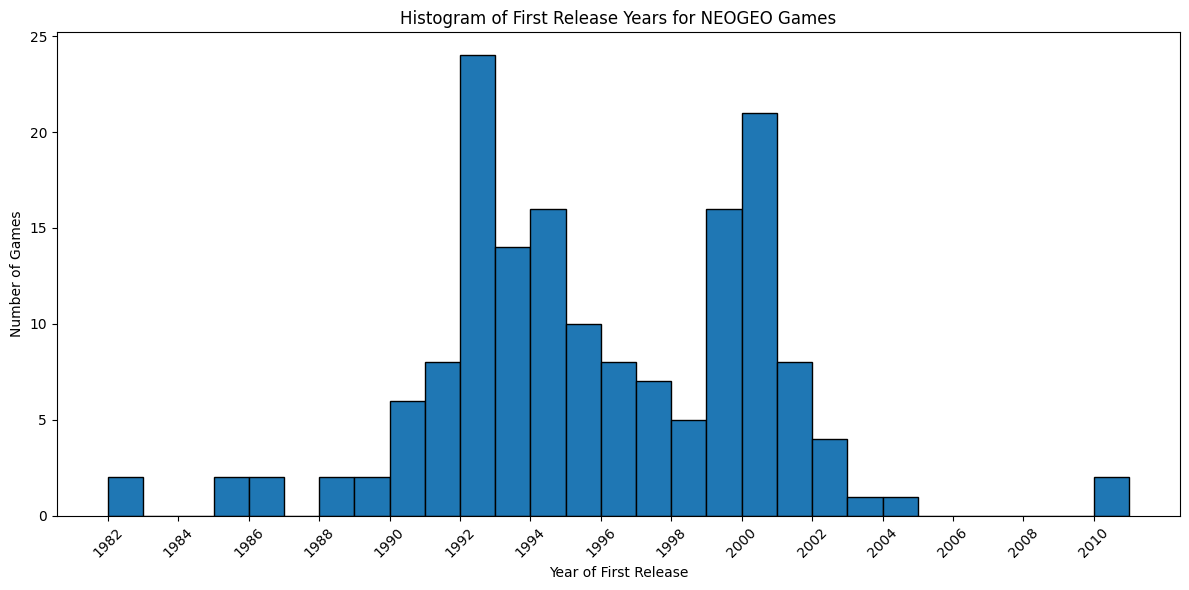

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Path to your CSV
csv_file = "../data/metadata/videogames_metadata.csv"

# Read CSV
df = pd.read_csv(csv_file)

# Ensure 'first_release_year' is numeric (some entries may be empty)
df['first_release_year'] = pd.to_numeric(df['first_release_year'], errors='coerce')

# Drop NaN values
df = df.dropna(subset=['first_release_year'])

# Plot histogram
plt.figure(figsize=(12,6))
plt.hist(df['first_release_year'], bins=range(int(df['first_release_year'].min()), int(df['first_release_year'].max()) + 2), edgecolor='black')
plt.xlabel("Year of First Release")
plt.ylabel("Number of Games")
plt.title("Histogram of First Release Years for NEOGEO Games")
plt.xticks(range(int(df['first_release_year'].min()), int(df['first_release_year'].max()) + 1, 2), rotation=45)
plt.tight_layout()
plt.show()

In [13]:
df = pd.read_csv("../data/metadata/videogames_metadata.csv")

# Check for duplicates in 'id'
duplicates = df[df.duplicated(subset='id', keep=False)]

if not duplicates.empty:
    print("Duplicate IDs found:")
    # print id of duplicates
    print(duplicates['id'].unique())
else:
    print("No duplicate IDs.")

Duplicate IDs found:
[281495   6556  15432  59500  15426  10605   1404  19986  37280  39983
  15431  15430  15428  12588   4435  76045  37251  52191   1408  71128
   5385  39653  19109  39347  18840 321578   4514   6800   5884  39531
  46779 242130   4275   1655   4501   4449   4388   5465  19769   5388
   3198   5334   4293   5395   5451   5405   5428   5460  93049   4403
   4379   5401 139169   2205   5437   5378   5430    968]
